# DLinear

시작 전에 파이썬 버전과 GPU 정보, CUDA 가용 여부를 확인한다.

In [1]:
!python --version

Python 3.7.15


In [2]:
!nvidia-smi

Fri Oct 28 15:02:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
torch.cuda.is_available()

True

## 데이터셋

ETTh1 데이터셋을 다운로드한다. ETT(Electricity Transformer Temperature) 데이터셋은 2016년 7월부터 2018년 7월까지 측정된 중국의 전기 변압기 온도에 대한 시계열 데이터다. 각 컬럼의 의미는 아래 표와 같다.

| Field | date | HUFL | HULL | MUFL | MULL | LUFL | LULL | OT |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| Description | The recorded **date** |**H**igh **U**se**F**ul **L**oad | **H**igh **U**se**L**ess **L**oad | **M**iddle **U**se**F**ul **L**oad | **M**iddle **U**se**L**ess **L**oad | **L**ow **U**se**F**ul **L**oad | **L**ow **U**se**L**ess **L**oad | **O**il **T**emperature (target) |

타겟 컬럼은 OT(Oil Temperature)이다. 오일 온도는 변압기의 상태에 따라 변하며, 특히 전기 사용량이 많아지는 시기에 온도가 상승한다. 오일 온도가 너무 높으면 변압기가 손상되어 대규모 정전 사태를 야기할 수 있기 때문에 변압기의 오일 온도가 안전한지 예측하는 것은 중요한 문제다.

In [4]:
%cd /content
!mkdir -p dataset
!curl https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv > dataset/ETTh1.csv

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2528k  100 2528k    0     0  2828k      0 --:--:-- --:--:-- --:--:-- 2825k


In [5]:
import pandas as pd
data = pd.read_csv('/content/dataset/ETTh1.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    17420 non-null  object 
 1   HUFL    17420 non-null  float64
 2   HULL    17420 non-null  float64
 3   MUFL    17420 non-null  float64
 4   MULL    17420 non-null  float64
 5   LUFL    17420 non-null  float64
 6   LULL    17420 non-null  float64
 7   OT      17420 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


날짜에 따른 OT(Oil temperature) 변화를 시각화해 확인해본다. 여기에서는 336건의 과거 시점(그래프에서 파란색 선)을 바탕으로 96건의 미래 시점(그래프에서 주황색 선)을 예측할 것이다. 

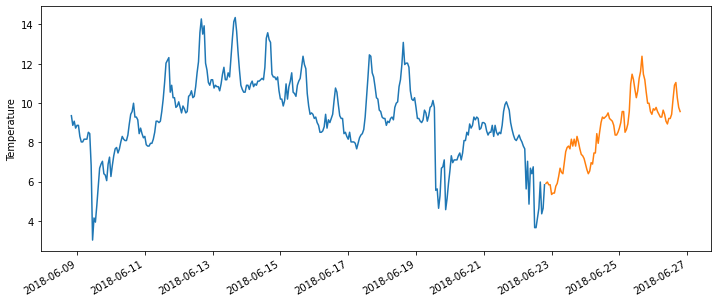

In [7]:
import matplotlib.pyplot as plt

seq_len = 336
pred_len = 96

plt.figure(figsize=(12,5))
plt.ylabel('Temperature')
data_to_show = data.set_index(pd.to_datetime(data['date']))
plt.plot(data_to_show['OT'][-(seq_len + pred_len):-pred_len])
plt.plot(data_to_show['OT'][-pred_len:])
plt.gcf().autofmt_xdate()
plt.show()

## 구현체 다운로드 및 패키지 설치

([A. Zeng, 2022](https://arxiv.org/pdf/2205.13504v2.pdf))에서 제시된 것과 같은 DLinear의 pytorch 구현체를 다운로드하고, 필요한 파이썬 패키지를 설치한다. 논문에서 제공하는 구현체가 ground truth에 대한 npy 파일을 생성하지 않도록 되어 있어서 구현체를 fork해 파일을 생성하도록 변경했다.

In [8]:
%cd /content
!rm -rf LTSF-Linear
!git clone https://github.com/parksb/LTSF-Linear.git
%cd /content/LTSF-Linear
!ls

/content
Cloning into 'LTSF-Linear'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 304 (delta 145), reused 277 (delta 137), pack-reused 0
Receiving objects: 100% (304/304), 5.79 MiB | 19.43 MiB/s, done.
Resolving deltas: 100% (145/145), done.
/content/LTSF-Linear
data_provider  layers	pics	    requirements.txt  scripts
exp	       LICENSE	Pyraformer  run_longExp.py    utils
FEDformer      models	README.md   run_stat.py       weight_plot.py


In [9]:
#!pip install -r requirements.txt

## 학습 및 테스트

각종 파라미터를 조정한다. 여기서는 `seq_len`(336)건의 과거 시계열 데이터를 학습해 `pred_len`(96)건의 미래 시계열을 예측한다.

In [10]:
import os
import torch
import random
import numpy as np
from utils.tools import dotdict
from exp.exp_main import Exp_Main

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

args = dotdict()
args.root_path = '/content/dataset/'
args.data_path = 'ETTh1.csv'
args.model_id = 'ETTh1_' + str(seq_len) + '_' + str(pred_len)
args.model = 'DLinear'
args.data = 'ETTh1'
args.features = 'M'

args.seq_len = seq_len
args.pred_len = pred_len

args.enc_in = 7
args.des = 'Exp'
args.target = 'OT'
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.label_len = 48
args.individual = False
args.embed_type = 0
args.dec_in = 7
args.c_out = 7
args.d_model = 512
args.n_heads = 8
args.e_layers = 2
args.d_layers = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = True
args.dropout = 0.05
args.embed = 'timeF'
args.activation = 'gelu'
args.num_workers = 10
args.train_epochs = 10
args.batch_size = 32
args.patience = 3
args.learning_rate = 0.0005
args.loss = 'mse'
args.lradj = 'type1'

args.use_amp = False
args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0
args.use_multi_gpu = False
args.devices = '0,1,2,3'
args.test_flop = False

if args.use_gpu and args.use_multi_gpu:
  args.dvices = args.devices.replace(' ', '')
  device_ids = args.devices.split(',')
  args.device_ids = [int(id_) for id_ in device_ids]
  args.gpu = args.device_ids[0]

setting = ''
exp = Exp_Main(args)
setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_0'.format(
    args.model_id, args.model, args.data, args.features, args.seq_len, args.label_len, args.pred_len,
    args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.factor, args.embed, args.distil, args.des)

Use GPU: cuda:0


조정된 파라미터에 따라 학습한다.

In [11]:
exp.train(setting)

train 8209
val 2785
test 2785
	iters: 100, epoch: 1 | loss: 0.3700325
	speed: 0.0192s/iter; left time: 47.3126s
	iters: 200, epoch: 1 | loss: 0.3430304
	speed: 0.0111s/iter; left time: 26.1882s
Epoch: 1 cost time: 3.861717939376831
Epoch: 1, Steps: 256 | Train Loss: 0.4088630 Vali Loss: 0.6664551 Test Loss: 0.3947056
Validation loss decreased (inf --> 0.666455).  Saving model ...
Updating learning rate to 0.0005
	iters: 100, epoch: 2 | loss: 0.4436035
	speed: 0.0633s/iter; left time: 139.5161s
	iters: 200, epoch: 2 | loss: 0.3813843
	speed: 0.0116s/iter; left time: 24.4041s
Epoch: 2 cost time: 3.796052932739258
Epoch: 2, Steps: 256 | Train Loss: 0.3486942 Vali Loss: 0.6676258 Test Loss: 0.3806984
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00025
	iters: 100, epoch: 3 | loss: 0.4300076
	speed: 0.0638s/iter; left time: 124.2724s
	iters: 200, epoch: 3 | loss: 0.3399374
	speed: 0.0107s/iter; left time: 19.8014s
Epoch: 3 cost time: 3.710273027420044
Epoch: 3, Steps: 256 | 

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=96, bias=True)
)

학습된 모델로 예측을 테스트한다. 이때 MSE, MAE 지표를 확인할 수 있다.

In [12]:
exp.test(setting, test=1)
torch.cuda.empty_cache()

test 2785
loading model
test shape: (87, 32, 96, 7) (87, 32, 96, 7)
test shape: (2784, 96, 7) (2784, 96, 7)
mse:0.3782263696193695, mae:0.4001270532608032


예측 데이터를 실제 데이터와 함께 시각화해보면 아래와 같다.

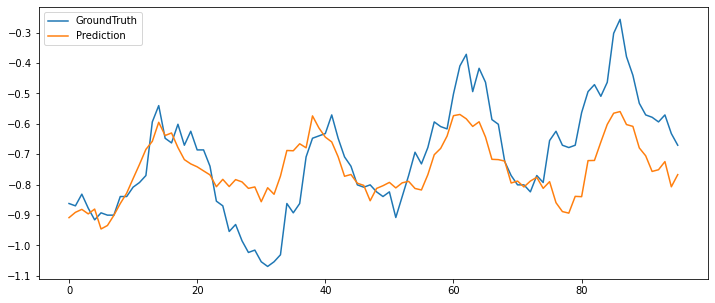

In [13]:
pred = np.load('./results/{}/pred.npy'.format(setting))
trues = np.load('./results/{}/true.npy'.format(setting))

plt.figure(figsize=(12, 5))
plt.plot(trues[0,:,-1], label="GroundTruth")
plt.plot(pred[0,:,-1], label="Prediction")
plt.legend()
plt.show()